In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, svm
import numpy as np

import matplotlib.pyplot as plt

import xgboost


pd.options.display.float_format = '{:.2f}'.format

df = pd.read_csv('sc2egset.csv')

In [2]:
# Filter out short matches and convert outcome values to int
df = df[(df.outcome.isin(['Win', 'Loss'])) & (df.game_time_gameloop > 12000)]
df['outcome'] = [1 if i == 'Win' else 0 for i in df.outcome]

In [3]:
# Filter out errant gameloops and ensure that the match represents only two players
grouped = df.groupby('gameloop')['game_hash'].nunique().reset_index()
good_loops = grouped[grouped.game_hash > 1000]['gameloop'].tolist()

grouped = df.groupby('game_hash')['player_name'].agg(list).reset_index()
grouped['player_count'] = [len(set(i)) for i in grouped.player_name]
correct_players = grouped[grouped.player_count == 2]['game_hash'].tolist()

df = df[(df.gameloop.isin(good_loops)) & (df.game_hash.isin(correct_players))]

In [4]:
# Define function to apply all three models to each time point in match, same approach as in classification made for time-aggregated data
def timepoint_fit(data, time):

    data = data[data.gameloop == time]

    model_features = ['foodMade', 'foodUsed', 'mineralsCollectionRate', 'mineralsCurrent', 'mineralsKilledArmy', 'mineralsKilledEconomy',
                      'mineralsKilledTechnology', 'mineralsUsedCurrentArmy', 'mineralsUsedCurrentEconomy', 'mineralsUsedCurrentTechnology',
                      'vespeneCollectionRate', 'vespeneCurrent', 'vespeneKilledArmy', 'vespeneKilledTechnology',
                      'vespeneUsedCurrentArmy', 'vespeneUsedCurrentEconomy', 'vespeneUsedCurrentTechnology', 'workersActiveCount']

    min_count = data.outcome.value_counts().min()
    df_model = data.groupby('outcome').sample(n=min_count)

    random_state = 22

    y = np.array(df_model['outcome'], dtype=int)
    X = np.asarray(df_model[model_features])
    X = preprocessing.StandardScaler().fit(X).transform(X)

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    xgb = xgboost.XGBClassifier(objective="binary:logistic", booster='gbtree', eta=0.2, max_depth=5, use_label_encoder=False, verbosity=0, random_state=random_state)
    xgb_scores = cross_val_score(xgb, X, y, cv=cv, n_jobs=-1)
    print("XGBoost: %0.4f accuracy with a standard deviation of %0.4f" % (xgb_scores.mean(), xgb_scores.std()))

    sv = svm.SVC(kernel='rbf', C=10, gamma='auto', random_state=random_state)
    sv_scores = cross_val_score(sv, X, y, cv=cv, n_jobs=-1)
    print("SVM: %0.4f accuracy with a standard deviation of %0.4f" % (sv_scores.mean(), sv_scores.std()))

    lr = LogisticRegression(C=10, penalty='l2', random_state=random_state)
    lr_scores = cross_val_score(lr, X, y, cv=cv, n_jobs=-1)
    print("Logistic Regression: %0.4f accuracy with a standard deviation of %0.4f" % (lr_scores.mean(), lr_scores.std()))

    return sv_scores.mean(), sv_scores.std(), lr_scores.mean(), lr_scores.std(), xgb_scores.mean(), xgb_scores.std(), model_features

In [5]:
# Apply models to each time point, limiting the max length of the match. Collect outputs for plotting.
out_dict = {'gameloop': [], 'sv_accuracy': [], 'sv_std': [], 'lr_accuracy': [], 'lr_std': [], 'xgb_accuracy': [], 'xgb_std': []}

filtered_loops = [i for i in good_loops if i <= 20000]
for count, loop in enumerate(filtered_loops):
    print("Processing loop "+str(count)+" of "+str(len(filtered_loops)))
    sv_accuracy, sv_std, lr_accuracy, lr_std, xgb_accuracy, xgb_std, features = timepoint_fit(df, loop)
    out_dict['gameloop'].append(loop)
    out_dict['sv_accuracy'].append(sv_accuracy)
    out_dict['sv_std'].append(sv_std)
    out_dict['lr_accuracy'].append(lr_accuracy)
    out_dict['lr_std'].append(lr_std)
    out_dict['xgb_accuracy'].append(xgb_accuracy)
    out_dict['xgb_std'].append(xgb_std)

Processing loop 0 of 126
XGBoost: 0.5147 accuracy with a standard deviation of 0.0060
SVM: 0.5147 accuracy with a standard deviation of 0.0060
Logistic Regression: 0.5147 accuracy with a standard deviation of 0.0060
Processing loop 1 of 126
XGBoost: 0.5110 accuracy with a standard deviation of 0.0051
SVM: 0.5146 accuracy with a standard deviation of 0.0081
Logistic Regression: 0.5155 accuracy with a standard deviation of 0.0059
Processing loop 2 of 126
XGBoost: 0.5165 accuracy with a standard deviation of 0.0079
SVM: 0.5179 accuracy with a standard deviation of 0.0079
Logistic Regression: 0.5134 accuracy with a standard deviation of 0.0092
Processing loop 3 of 126
XGBoost: 0.5225 accuracy with a standard deviation of 0.0053
SVM: 0.5208 accuracy with a standard deviation of 0.0034
Logistic Regression: 0.5172 accuracy with a standard deviation of 0.0046
Processing loop 4 of 126
XGBoost: 0.5134 accuracy with a standard deviation of 0.0034
SVM: 0.5138 accuracy with a standard deviation of 

XGBoost: 0.5533 accuracy with a standard deviation of 0.0078
SVM: 0.5468 accuracy with a standard deviation of 0.0050
Logistic Regression: 0.5617 accuracy with a standard deviation of 0.0078
Processing loop 39 of 126
XGBoost: 0.5617 accuracy with a standard deviation of 0.0063
SVM: 0.5641 accuracy with a standard deviation of 0.0073
Logistic Regression: 0.5649 accuracy with a standard deviation of 0.0049
Processing loop 40 of 126
XGBoost: 0.5643 accuracy with a standard deviation of 0.0064
SVM: 0.5612 accuracy with a standard deviation of 0.0049
Logistic Regression: 0.5680 accuracy with a standard deviation of 0.0072
Processing loop 41 of 126
XGBoost: 0.5677 accuracy with a standard deviation of 0.0027
SVM: 0.5631 accuracy with a standard deviation of 0.0017
Logistic Regression: 0.5693 accuracy with a standard deviation of 0.0033
Processing loop 42 of 126
XGBoost: 0.5709 accuracy with a standard deviation of 0.0016
SVM: 0.5673 accuracy with a standard deviation of 0.0027
Logistic Regre

XGBoost: 0.6737 accuracy with a standard deviation of 0.0045
SVM: 0.6776 accuracy with a standard deviation of 0.0056
Logistic Regression: 0.6705 accuracy with a standard deviation of 0.0062
Processing loop 77 of 126
XGBoost: 0.6775 accuracy with a standard deviation of 0.0102
SVM: 0.6799 accuracy with a standard deviation of 0.0106
Logistic Regression: 0.6728 accuracy with a standard deviation of 0.0065
Processing loop 78 of 126
XGBoost: 0.6783 accuracy with a standard deviation of 0.0051
SVM: 0.6756 accuracy with a standard deviation of 0.0054
Logistic Regression: 0.6718 accuracy with a standard deviation of 0.0054
Processing loop 79 of 126
XGBoost: 0.6789 accuracy with a standard deviation of 0.0062
SVM: 0.6797 accuracy with a standard deviation of 0.0049
Logistic Regression: 0.6731 accuracy with a standard deviation of 0.0060
Processing loop 80 of 126
XGBoost: 0.6793 accuracy with a standard deviation of 0.0056
SVM: 0.6795 accuracy with a standard deviation of 0.0057
Logistic Regre

XGBoost: 0.6833 accuracy with a standard deviation of 0.0115
SVM: 0.6732 accuracy with a standard deviation of 0.0115
Logistic Regression: 0.6860 accuracy with a standard deviation of 0.0086
Processing loop 115 of 126
XGBoost: 0.6805 accuracy with a standard deviation of 0.0089
SVM: 0.6782 accuracy with a standard deviation of 0.0088
Logistic Regression: 0.6905 accuracy with a standard deviation of 0.0097
Processing loop 116 of 126
XGBoost: 0.6827 accuracy with a standard deviation of 0.0036
SVM: 0.6721 accuracy with a standard deviation of 0.0082
Logistic Regression: 0.6881 accuracy with a standard deviation of 0.0035
Processing loop 117 of 126
XGBoost: 0.6737 accuracy with a standard deviation of 0.0046
SVM: 0.6704 accuracy with a standard deviation of 0.0052
Logistic Regression: 0.6926 accuracy with a standard deviation of 0.0105
Processing loop 118 of 126
XGBoost: 0.6733 accuracy with a standard deviation of 0.0027
SVM: 0.6725 accuracy with a standard deviation of 0.0053
Logistic R

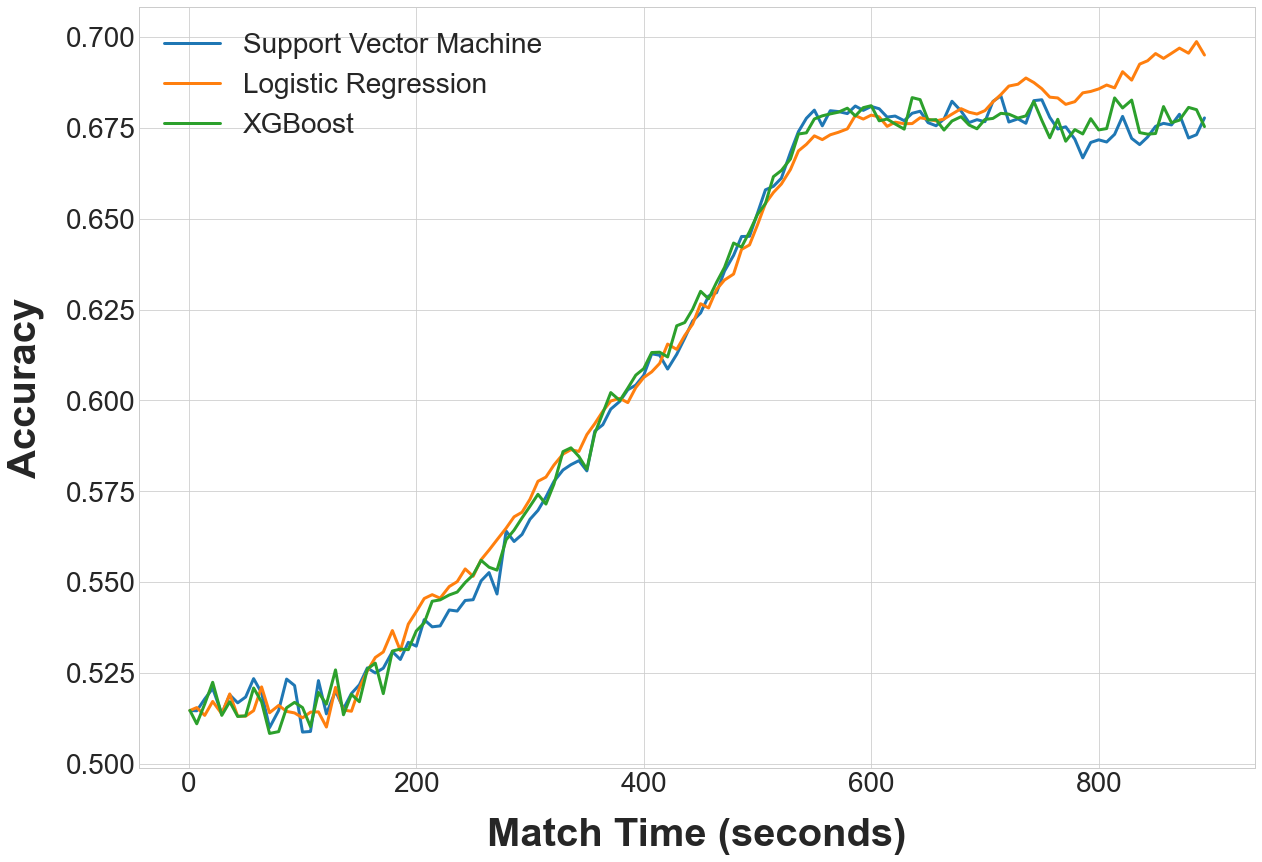

In [6]:
# Plot each model's accuracy over time

time = [round(i/22.4) if i > 1 else i for i in out_dict['gameloop']]

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(20, 14))

ax.plot(time, out_dict['sv_accuracy'], label='Support Vector Machine', linewidth=3)
ax.plot(time, out_dict['lr_accuracy'], label='Logistic Regression', linewidth=3)
ax.plot(time, out_dict['xgb_accuracy'], label='XGBoost', linewidth=3)

ax.set_xlabel('Match Time (seconds)', fontsize=40, labelpad=20, fontdict=dict(weight='bold'))
ax.set_ylabel('Accuracy', fontsize=40, labelpad=22, fontdict=dict(weight='bold'))
plt.legend(fontsize=28)
plt.yticks(fontsize=28)
plt.xticks(fontsize=28)
plt.savefig('timeseries.pdf', dpi=600)
plt.show()